In [ ]:
# install R kernel
#install.packages('IRkernel')
#IRkernel::installspec(user = FALSE)  # To install system-wide


https://ucdavis-bioinformatics-training.github.io/2022-June-RNA-Seq-Analysis/data_analysis/DE_Analysis_mm_with_quizzes_fixed
https://ucdavis-bioinformatics-training.github.io/2022-June-RNA-Seq-Analysis/data_reduction/03-counts_mm
https://github.com/ben-laufer/RNA-seq/blob/main/04-limma-voom.R
https://raw.githubusercontent.com/ucdavis-bioinformatics-training/2020-mRNA_Seq_Workshop/master/data_analysis/enrichment_mm.Rmd
https://bioconductor.org/packages/release/bioc/vignettes/biomaRt/inst/doc/accessing_ensembl.html#selecting-an-ensembl-biomart-database-and-dataset
https://cran.r-project.org/web/packages/enrichR/vignettes/enrichR.html


BiocManager::install("clusterProfiler")

In [6]:
BiocManager::install("clusterProfiler", lib = "/quobyte/lasallegrp/programs/.conda/envs//DMRichR_R4.2/lib/R//library")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Warning message:
“unable to access index for repository https://bioconductor.org/packages/3.16/bioc/src/contrib:
  cannot open URL 'https://bioconductor.org/packages/3.16/bioc/src/contrib/PACKAGES'”
Warning message:
“unable to access index for repository https://bioconductor.org/packages/3.16/data/annotation/src/contrib:
  cannot open URL 'https://bioconductor.org/packages/3.16/data/annotation/src/contrib/PACKAGES'”
Warning message:
“unable to access index for repository https://bioconductor.org/packages/3.16/data/experiment/src/contrib:
  cannot open URL 'https://bioconductor.org/packages/3.16/data/experiment/src/contrib/PACKAGES'”
Bioconductor version 3.16 (BiocManager 1.30.25), R 4.2.3 (2023-03-15)

Installing package(s) 'clusterProfiler'

Updating HTML index of packages in '.Library'

Makin

In [8]:
BiocManager::install("org.Mmu.eg.db", lib = "/quobyte/lasallegrp/programs/.conda/envs//DMRichR_R4.2/lib/R//library")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.16 (BiocManager 1.30.25), R 4.2.3 (2023-03-15)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'org.Mmu.eg.db'”
Old packages: 'AnnotationDbi', 'aplot', 'BH', 'BiocParallel', 'biocViews',
  'biomaRt', 'bit', 'ChIPseeker', 'cli', 'cpp11', 'curl', 'data.table',
  'DESeq2', 'dmrseq', 'DOSE', 'edgeR', 'genefilter', 'GenomicAlignments',
  'GenomicFeatures', 'GenomicRanges', 'ggnewscale', 'ggraph', 'ggtree',
  'graphlayouts', 'httr2', 'igraph', 'locfit', 'openxlsx', 'processx', 'ps',
  'purrr', 'R.utils', 'R6', 'ragg', 'RcppArmadillo', 'RcppTOML', 'RCurl',
  'readxl', 'recipes', 'reticulate', 'rGREAT', 'rhdf5', 'rhdf5filters',
  'rjson', 'RSpectra', 'RSQLite', 'S4Vectors', 'shadowtext', 'slam', 'Spa

In [6]:
# Load the libraries
library(clusterProfiler)
library(org.Mmu.eg.db)  # Replace 'Hs' with the appropriate organism code
library(biomaRt)
library(KEGGREST)
library(enrichplot)
library(ggplot2)
library(DOSE)
#for each cluster separate

library(ggplot2)
library(biomaRt)
  # Load the Rhesus macaque database



Attaching package: ‘dplyr’


The following object is masked from ‘package:biomaRt’:

    select


The following object is masked from ‘package:AnnotationDbi’:

    select


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


'select()' returned 1:many mapping between keys and columns

Warning message in bitr(ensembl_ids, fromType = "ENSEMBL", toType = "ENTREZID", :
“22.67% of input gene IDs are fail to map...”
Reading KEGG annotation online: "https://rest.kegg.jp/link/mcc

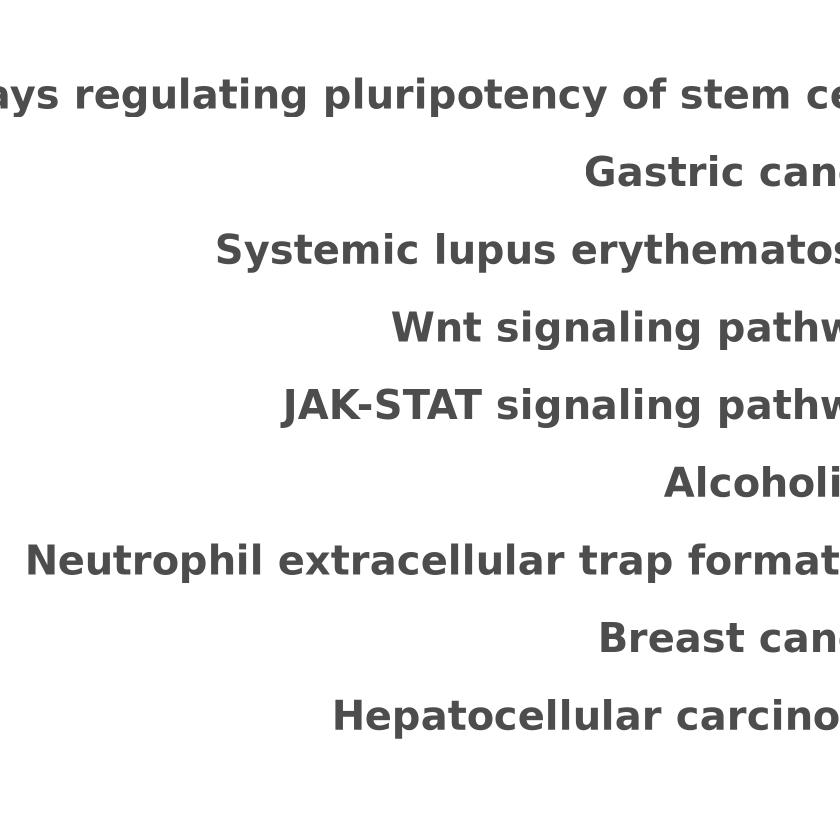

In [2]:
# KEGG enrichment analysis for each content type
library(clusterProfiler)
library(ggplot2)
library(dplyr)
library(biomaRt)
library(org.Mmu.eg.db)  # Load the Rhesus macaque database

# Define the content types
contents <- c("mCG", "mCH")

# Loop through each content type
for (content in contents) {

    # Construct the file path for each content type
    file_path <- paste0('./', content, '_dmgs', '.csv')
    
    # Read the CSV file
    ensembl_df <- read.csv(file_path)
    
    # Convert the first column to a character vector (assuming it contains Ensembl IDs)
    ensembl_ids <- as.character(ensembl_df[[3]])
    
    # Convert Ensembl IDs to Entrez IDs using bitr
    entrezid <- bitr(ensembl_ids, fromType = "ENSEMBL", toType = "ENTREZID", OrgDb = 'org.Mmu.eg.db')
    
    # Check if there are valid Entrez IDs
    if (is.null(entrezid) || nrow(entrezid) == 0) {
      message(paste("No valid Entrez IDs for", content))
      next  # Skip to the next iteration if no valid Entrez IDs
    }
    
    # Perform KEGG enrichment analysis
    kegg_enrich <- enrichKEGG(
      gene = entrezid$ENTREZID,
      organism = "mcc",       # "mcc" is the organism code for Macaca mulatta
      pAdjustMethod = "BH",
      pvalueCutoff = 0.1,
      qvalueCutoff = 0.1
    )
    
    # Check if KEGG enrichment results are available
    if (is.null(kegg_enrich) || nrow(as.data.frame(kegg_enrich)) == 0) {
      message(paste("No significant KEGG pathways for", content))
      next  # Skip to the next iteration if no significant results
    }
    
    # Clean the pathway names by removing the organism name
    kegg_enrich@result$Description <- gsub("- Macaca mulatta \\(rhesus monkey\\)", "", kegg_enrich@result$Description)
    
    # Convert KEGG results to a data frame
    kegg_df <- as.data.frame(kegg_enrich)
    
    # Calculate Odds Ratio if it's missing
    if (!"OddsRatio" %in% colnames(kegg_df)) {
      if ("GeneRatio" %in% colnames(kegg_df) && "BgRatio" %in% colnames(kegg_df)) {
        # Calculate Odds Ratio based on GeneRatio and BgRatio
        gene_ratio <- as.numeric(sapply(strsplit(kegg_df$GeneRatio, "/"), function(x) as.numeric(x[1]) / as.numeric(x[2])))
        bg_ratio <- as.numeric(sapply(strsplit(kegg_df$BgRatio, "/"), function(x) as.numeric(x[1]) / as.numeric(x[2])))
        kegg_df$OddsRatio <- gene_ratio / bg_ratio
      } else {
        message(paste("Cannot calculate Odds Ratio for", content))
        next  # Skip if Odds Ratio can't be calculated
      }
    }
    
    # Sort by raw p-value and take the top 10 pathways
    kegg_df <- kegg_df[order(kegg_df$pvalue), ]
    kegg_df_top10 <- head(kegg_df, 10)
    
    # Plot the KEGG enrichment results using p-value and Odds Ratio
    p2 <- ggplot(kegg_df_top10, aes(x = reorder(Description, -pvalue), y = OddsRatio)) +
      geom_point(aes(size = Count, color = pvalue)) +  # Color by p-value and size by gene count
      coord_flip() +
      scale_color_gradient(low = "red", high = "blue") +  # Customize color scale
      labs(
        title = paste("KEGG Pathway Enrichment Analysis for", content),
        x = "-log10(p-value)",
        y = "Odds Ratio"
      ) +
      theme_minimal() +
      theme(
                axis.text.x = element_text(size= 18, face = "bold"),
          axis.title = element_text(face = "bold", size = 18),
        axis.text.y = element_text(size = 24, face = "bold"),  # Increase y-axis text size for readability
        plot.title = element_text(size = 18, face = "bold")  # Increase title size and make it bold
      )
    
    # Save the plot to a file with a unique filename
    plot_filename <- paste0("kegg_", content, "_top10_0.1pvalnn.png")
    ggsave(plot_filename, plot = p2, width = 14, height = 12, dpi = 300)
     write.table(kegg_df, file = paste0(content, "_kegg_results_0.1pvalnn.csv"), sep = ",", row.names = FALSE)
    # Print the plot for visual inspection
    print(p2)
}


'select()' returned 1:many mapping between keys and columns

Warning message in bitr(ensembl_ids, fromType = "ENSEMBL", toType = "ENTREZID", :
“22.67% of input gene IDs are fail to map...”
'select()' returned 1:many mapping between keys and columns

Warning message in bitr(ensembl_ids, fromType = "ENSEMBL", toType = "ENTREZID", :
“34.06% of input gene IDs are fail to map...”
No significant KEGG pathways for mCH



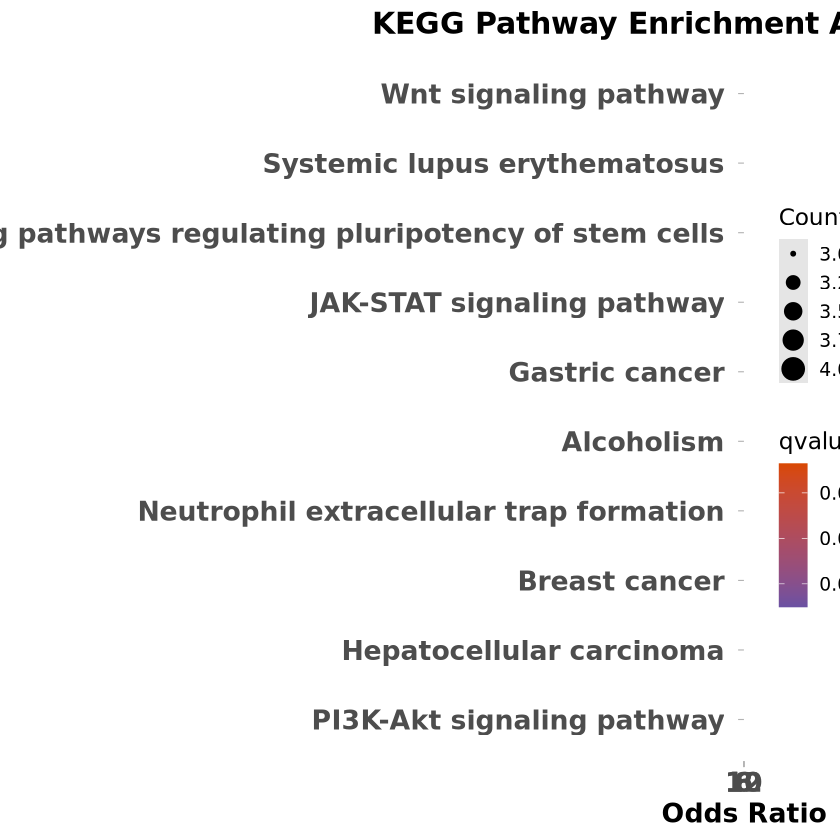

In [12]:
# KEGG enrichment analysis for each content type using q-value
library(clusterProfiler)
library(ggplot2)
library(dplyr)
library(biomaRt)
library(org.Mmu.eg.db)  # Load the Rhesus macaque database

# Define the content types
contents <- c("mCG", "mCH")

# Loop through each content type
for (content in contents) {
  
  # Construct the file path for each content type
  file_path <- paste0('./', content, '_dmgs', '.csv')
  
  # Read the CSV file
  ensembl_df <- read.csv(file_path)
  
  # Convert the first column to a character vector (assuming it contains Ensembl IDs)
  ensembl_ids <- as.character(ensembl_df[[3]])
  
  # Convert Ensembl IDs to Entrez IDs using bitr
  entrezid <- bitr(
    ensembl_ids, 
    fromType = "ENSEMBL", 
    toType   = "ENTREZID", 
    OrgDb    = 'org.Mmu.eg.db'
  )
  
  # Check if there are valid Entrez IDs
  if (is.null(entrezid) || nrow(entrezid) == 0) {
    message(paste("No valid Entrez IDs for", content))
    next  # Skip to the next iteration if no valid Entrez IDs
  }
  
  # Perform KEGG enrichment analysis
  kegg_enrich <- enrichKEGG(
    gene          = entrezid$ENTREZID,
    organism      = "mcc",  # "mcc" is the organism code for Macaca mulatta
    pAdjustMethod = "BH",
    pvalueCutoff  = 0.1,
    qvalueCutoff  = 0.1
  )
  
  # Check if KEGG enrichment results are available
  if (is.null(kegg_enrich) || nrow(as.data.frame(kegg_enrich)) == 0) {
    message(paste("No significant KEGG pathways for", content))
    next  # Skip to the next iteration if no significant results
  }
  
  # Clean the pathway names by removing the organism name
  kegg_enrich@result$Description <- gsub("- Macaca mulatta \\(rhesus monkey\\)", "", kegg_enrich@result$Description)
  
  # Convert KEGG results to a data frame
  kegg_df <- as.data.frame(kegg_enrich)
  
  # Calculate Odds Ratio if it's missing
  if (!"OddsRatio" %in% colnames(kegg_df)) {
    if ("GeneRatio" %in% colnames(kegg_df) && "BgRatio" %in% colnames(kegg_df)) {
      # Calculate Odds Ratio based on GeneRatio and BgRatio
      gene_ratio <- as.numeric(sapply(strsplit(kegg_df$GeneRatio, "/"), function(x) as.numeric(x[1]) / as.numeric(x[2])))
      bg_ratio   <- as.numeric(sapply(strsplit(kegg_df$BgRatio, "/"), function(x) as.numeric(x[1]) / as.numeric(x[2])))
      kegg_df$OddsRatio <- gene_ratio / bg_ratio
    } else {
      message(paste("Cannot calculate Odds Ratio for", content))
      next  # Skip if Odds Ratio can't be calculated
    }
  }
  
  # Sort by q-value and take the top 10 pathways
  kegg_df <- kegg_df[order(kegg_df$qvalue), ]
  kegg_df_top10 <- head(kegg_df, 10)
  
  # Plot the KEGG enrichment results using q-value and Odds Ratio
  p2 <- ggplot(kegg_df_top10, aes(x = reorder(Description, -qvalue), y = OddsRatio)) +
    geom_point(aes(size = Count, color = qvalue)) +
    coord_flip() +
    # Example of a purple-to-orange gradient; adjust as desired
    scale_color_gradient(low = "#6A51A3", high = "#D94801") +
    labs(
      title = paste("KEGG Pathway Enrichment Analysis for", content),
      x     = "-log10(q-value)",
      y     = "Odds Ratio"
    ) +
    # Switch to a light theme for a gray background and black borders
    theme_light(base_size = 14) +
    theme(
      # Make the panel background a light gray
      panel.background = element_rect(fill = "gray90"),
      # Add a black border around the plot panel
      panel.border     = element_rect(color = "black", fill = NA, size = 1),
      # Customize grid lines (make major grid lines white for contrast)
      panel.grid.major = element_line(color = "white"),
      panel.grid.minor = element_blank(),
      
      # Axis text/title styles
      axis.title       = element_text(face = "bold", size = 16),
      axis.text.x      = element_text(size = 16, face = "bold"),
      axis.text.y      = element_text(size = 16, face = "bold"),
      # Center and bold the plot title
      plot.title       = element_text(size = 18, face = "bold", hjust = 0.5)
    )
  
  # Save the plot to a file with a unique filename
  plot_filename <- paste0("kegg_", content, "_fig2.pdf")
  ggsave(plot_filename, plot = p2, width = 12, height = 7, dpi = 300)
  
  # Write out the full KEGG results
  write.table(
    kegg_df, 
    file      = paste0(content, "_kegg_results_0.1qvalnn.csv"), 
    sep       = ",", 
    row.names = FALSE
  )
  
  # Print the plot for visual inspection
  print(p2)
}
